In [1]:
# COSAS IMPORTADAS
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import scipy.fft as ft
import antropy as ant

c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\antropy\fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [2]:
# Función usada para filtrar cada señal obtenida
def filtrar(signal_input):
    # Filtro pasa altas a 0.5 Hz
    highpass_cutoff = 0.5
    b_highpass, a_highpass = signal.butter(4, highpass_cutoff, 'highpass', fs=250)
    signal_highpass = signal.filtfilt(b_highpass, a_highpass, signal_input)

    # Filtros band-stop de 57-63 Hz y 117-123 Hz
    bandstop1_lowcut = 57
    bandstop1_highcut = 63
    b_bandstop1, a_bandstop1 = signal.butter(4, [bandstop1_lowcut, bandstop1_highcut], 'bandstop', fs=250)
    signal_bandstop1 = signal.filtfilt(b_bandstop1, a_bandstop1, signal_highpass)

    bandstop2_lowcut = 117
    bandstop2_highcut = 123
    b_bandstop2, a_bandstop2 = signal.butter(4, [bandstop2_lowcut, bandstop2_highcut], 'bandstop', fs=250)
    signal_bandstop2 = signal.filtfilt(b_bandstop2, a_bandstop2, signal_bandstop1)

    # Filtro pasa banda de 6-25 Hz
    bandpass_lowcut = 6
    bandpass_highcut = 25
    b_bandpass, a_bandpass = signal.butter(4, [bandpass_lowcut, bandpass_highcut], 'bandpass', fs=250)
    signal_bandpass = signal.filtfilt(b_bandpass, a_bandpass, signal_bandstop2)
    signal_filtered=signal_bandpass

    return signal_filtered

In [3]:
# Función para detectar todos los picos mayores a un threshold
def detectar_picos(signal):
    inicia_pico=0
    threshold_p=23*0.02235 #Usamos este valor al analizar las señales y verificar que el ruido no se considere como pico
    pico_st=[]
    pico=[]
    pos=[]
    i=0

    while i<=(len(signal)-1):
        valor=signal[i]
        if inicia_pico==0: 
            if valor>threshold_p:  #Si el valor analizado es mayor al threshold, se toma que el pico inicia
                inicia_pico=1
                pico_st.append("incia")
                pico.append(valor)
                pos.append(i)

        if inicia_pico==1:
            if valor<= threshold_p: # Si el valor analizado es menor al threshold, se toma que el pico acaba
                inicia_pico=0

                pico_st.append("acaba")
                pico.append(valor)
                pos.append(i)

        i=i+1

    return pico_st, pico, pos   # Recolectamos tanto el estado del pico (inicia o acaba), el valor de la señal en estos estado, asi como la posición en el array de la señal 

In [4]:
# Función para agrupar los picos por cercanía

def agrupar_picos(pico,pos,pico_st):
    j=0
    pico_actual=[]
    picos=[]

    pos_pico_act=[]
    pos_picos_agrp=[]

    while j<=(len(pico)-4):
        if pico_st[j]=="incia":
        
            sigue=1
            pico_actual=[]
            pos_act=[]

            while sigue:
                pico_actual.append(pico[j])
                pos_act.append(pos[j])

                if ((j<(len(pos)-1) and pos[j+1]-pos[j]<=80)):
                    j=j+1
            
                else:
                    picos.append(pico_actual)
                    pos_picos_agrp.append(pos_act)

                    pico_actual=[]
                    pos_act=[]

                    sigue=0

        else:
            j=j+1

    return picos,pos_picos_agrp

In [5]:
# Se diferencia segúna la agrupación de picos si el grupo pertenece a una señal de pestañep corto o largo
# Condiciones: si el grupo presenta 1 pico, es corto
#              si el grupo presenta 2 picos, se analiza si entre picos existe algún pico que no supero el threshold
#                   si existe pico intermedio, es largo
#                   si no existe pico intermedio, es corto
#              si el grupo presenta más de 2 picos, es largo
    
def tipos_onda(pos_picos_agrp,signal):
    
    tipo_onda=[]
    i_f_onda=[]

    for i in pos_picos_agrp:
        if len(i)<=4:
            if len(i)==4:
                busqueda=signal[i[1]:i[2]]
            else:
                busqueda=signal[i[0]:i[1]]

            j=0
            n_0=0
            while j<=(len(busqueda)-2):
                if (busqueda[j]==0) or (busqueda[j] >0 and busqueda[j+1]<0) or (busqueda[j] <0 and busqueda[j+1]>0):
                    n_0=n_0+1

                j=j+1

            if n_0<=2:
                tipo_onda.append("corto")
            
            else:
                tipo_onda.append("largo")
            

        else:
            tipo_onda.append("largo")
        a=i[0]
        b=i[-1]
        i_f_onda.append([a,b])

    return tipo_onda,i_f_onda

In [6]:
# Función para delimitar 3 secciones de la señal de 10 segundos cada una

def partir_onda(tipo_onda,i_f_onda):
    ondas_0_10=[]; t_ondas_0_10=[]
    ondas_10_20=[]; t_ondas_10_20=[]
    ondas_20_30=[]; t_ondas_20_30=[]
    megalist=[]
    cont=0

    for i in i_f_onda:
        if i[0]<=2500:
            ondas_0_10.append(i)
            t_ondas_0_10.append(tipo_onda[i_f_onda.index(i)])

        elif i[0]>2500 and i[0]<=5000:
            ondas_10_20.append(i)
            t_ondas_10_20.append(tipo_onda[i_f_onda.index(i)])
        elif i[0]>5000:
            ondas_20_30.append(i)
            t_ondas_20_30.append(tipo_onda[i_f_onda.index(i)])
        
        megalist=[t_ondas_0_10,t_ondas_10_20,t_ondas_20_30]
    
    return megalist

In [7]:
# Función para determinar si cada sección pertenece a pestañeos cortos o largos

def codificar(megalist):
    codigo=""
    for i in megalist:
        punt=0
        for j in i:
            if j=="largo":
                punt=punt+1
            else:
                punt=punt-1
        
        if punt>0:
            codigo=codigo + "1"
        elif punt<0:
            codigo=codigo + "0"
        else:
            codigo=codigo + "error"
    return codigo

In [8]:
# Función para plotear la señal cruda, filtrada y el espectro de frecuencias
def plotear(signals,signals_f,times,titles,n):
    # Parámetros
    signal_input = signals[n]
    signal_filtered= signals_f[n]

    factor=0.02235

    t = times[n]
    title=titles[n]
    fs=250

    # Espectro de frecuencias antes del filtrado
    #frequencies_input, spectrum_input = signal.periodogram(signal_input, fs=250)

    # Espectro de frecuencias después del filtrado
    frequencies_output, spectrum_output = signal.periodogram(signal_filtered, fs=250)

    # Visualización de las señales originales y filtradas
    plt.figure(figsize=(10, 9))

    plt.subplot(3, 1, 1)
    plt.plot(t, signal_input)
    plt.title('Señal '+ title)
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')

    plt.subplot(3, 1, 2)
    plt.plot(t, signal_filtered)
    plt.title('Señal filtrada')
    plt.hlines(23*factor,0,max(t),color="green")
    plt.ylim(-100*factor,100*factor)
    plt.grid()
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')

    plt.subplot(3, 1, 3)
    plt.plot(frequencies_output, spectrum_output)
    plt.title('Espectro de frecuencias después del filtrado')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud')
    plt.xlim(0,30)

    plt.tight_layout()
    plt.show()

In [9]:
# Función para determinar si el grupo es de pestañeos cortos o largos
def tipo_grupo(grupo):
    suma=0
    for i in grupo:
        if i=="corto":
            suma=suma+1
        else:
            suma=suma-1
    
    if suma>0:
        return "Grupo de pestañeos cortos"
    
    if suma<0:
        return "Grupo de pestañeos largos"

In [10]:
#DATOS FS=250 Y TS=1/FS
Fs = 250  #Obtenido de ULTRACORTEX
Ts=1/Fs

In [11]:
# DATA IMPORTADA DE LOS TXT
PL = np.genfromtxt("./PL.txt", delimiter=", ",skip_header = 5)
PC = np.genfromtxt("./PC.txt", delimiter=", ",skip_header = 5)
P_OOC = np.genfromtxt("./P_OOC.txt", delimiter=", ",skip_header = 5)
P_OCO = np.genfromtxt("./P_OCO.txt", delimiter=", ",skip_header = 5)
P_COC = np.genfromtxt("./P_COC.txt", delimiter=", ",skip_header = 5)
P_CCO = np.genfromtxt("./P_CCO.txt", delimiter=", ",skip_header = 5)

In [12]:
# OBTENCIÓN DE LOS T's
M_PL = PL[:,1].shape[0]
n_PL = np.arange(0,M_PL)
T_PL = n_PL*Ts

M_PC = PC[:,1].shape[0]
n_PC = np.arange(0,M_PC)
T_PC = n_PC*Ts

M_P_OOC = P_OOC[:,1].shape[0]
n_P_OOC = np.arange(0,M_P_OOC)
T_P_OOC = n_P_OOC*Ts

M_P_OCO = P_OCO[:,1].shape[0]
n_P_OCO = np.arange(0,M_P_OCO)
T_P_OCO = n_P_OCO*Ts

M_P_COC = P_COC[:,1].shape[0]
n_P_COC = np.arange(0,M_P_COC)
T_P_COC = n_P_COC*Ts

M_P_CCO = P_CCO[:,1].shape[0]
n_P_CCO = np.arange(0,M_P_CCO)
T_P_CCO = n_P_CCO*Ts

In [13]:
# OBTENCION DE LA DATA Y DE LOS t's
CH1_PL = PL[1:,1];       t_PL = T_PL[1:]
CH1_PC = PC[1:,1];       t_PC = T_PC[1:]
CH1_P_OOC = P_OOC[1:,1]; t_P_OOC = T_P_OOC[1:]
CH1_P_OCO = P_OCO[1:,1]; t_P_OCO = T_P_OCO[1:]
CH1_P_COC = P_COC[1:,1]; t_P_COC = T_P_COC[1:]
CH1_P_CCO = P_CCO[1:,1]; t_P_CCO = T_P_CCO[1:]

signals=[CH1_PL, CH1_PC, CH1_P_OOC, CH1_P_OCO, CH1_P_COC, CH1_P_CCO]
times = [t_PL  , t_PC  , t_P_OOC  , t_P_OCO  , t_P_COC  , t_P_CCO  ]
titles= ["PL"  ,"PC"   ,"P_OOC"   ,"P_OCO"   ,"P_COC"   ,"P_CCO"]


In [14]:
#Obtención de señales filtrdas y conversión de unidades
signals_f=[]
for i in signals:
    signal_filtrada=filtrar(i)
    signal_filtrada=signal_filtrada*0.02235
    signals_f.append(signal_filtrada)


0 = P Largo, 1 = P Corto, 2 = P OOC, 3 = P_OCO, 4 = P_COC, 5 = P_CCO

In [15]:
# Señal a revisar
n=5

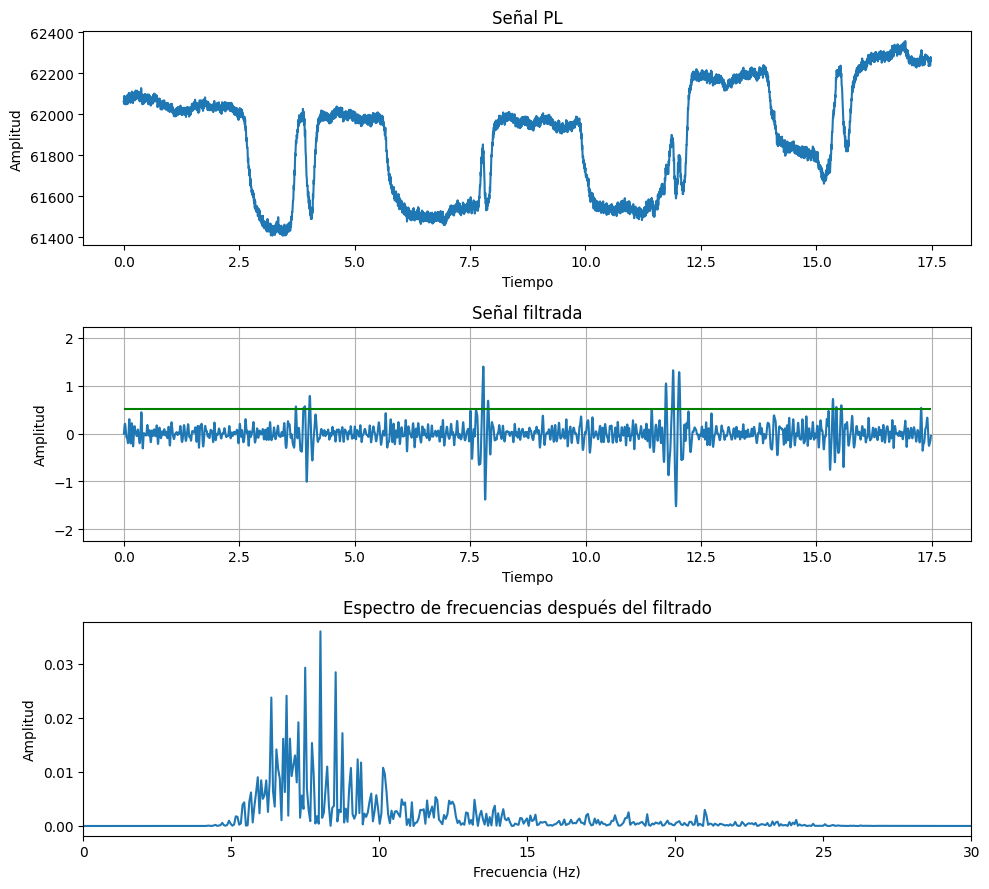

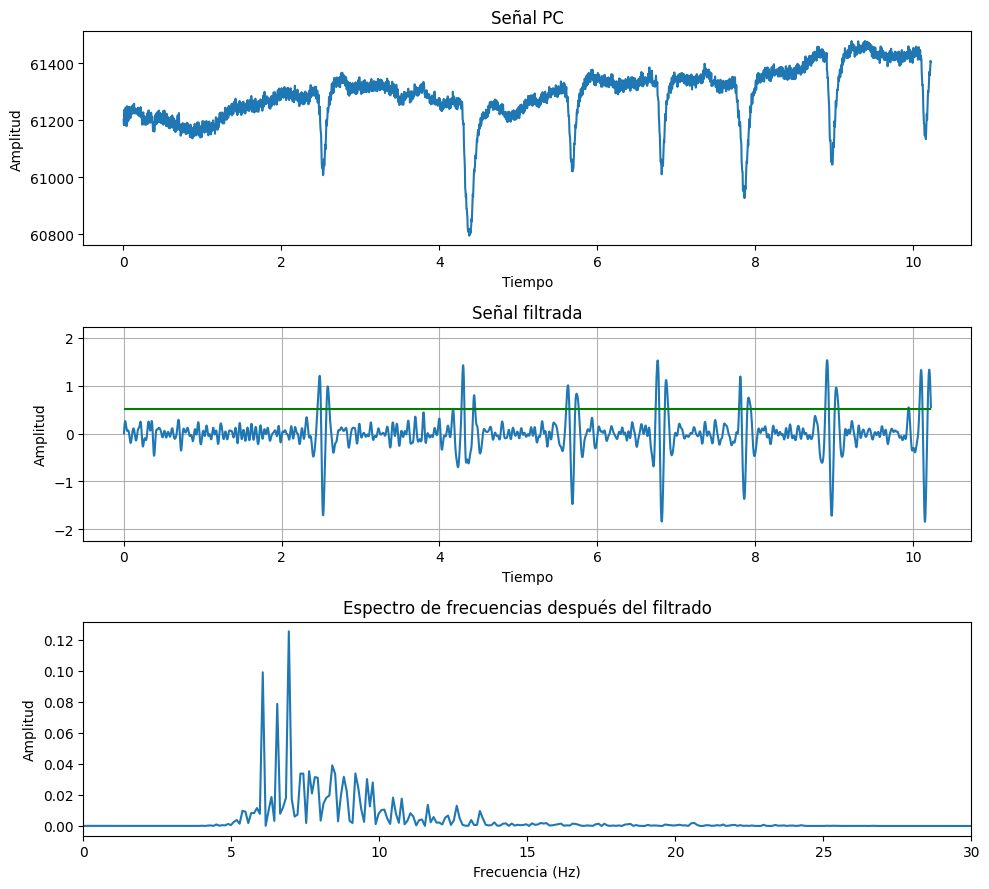

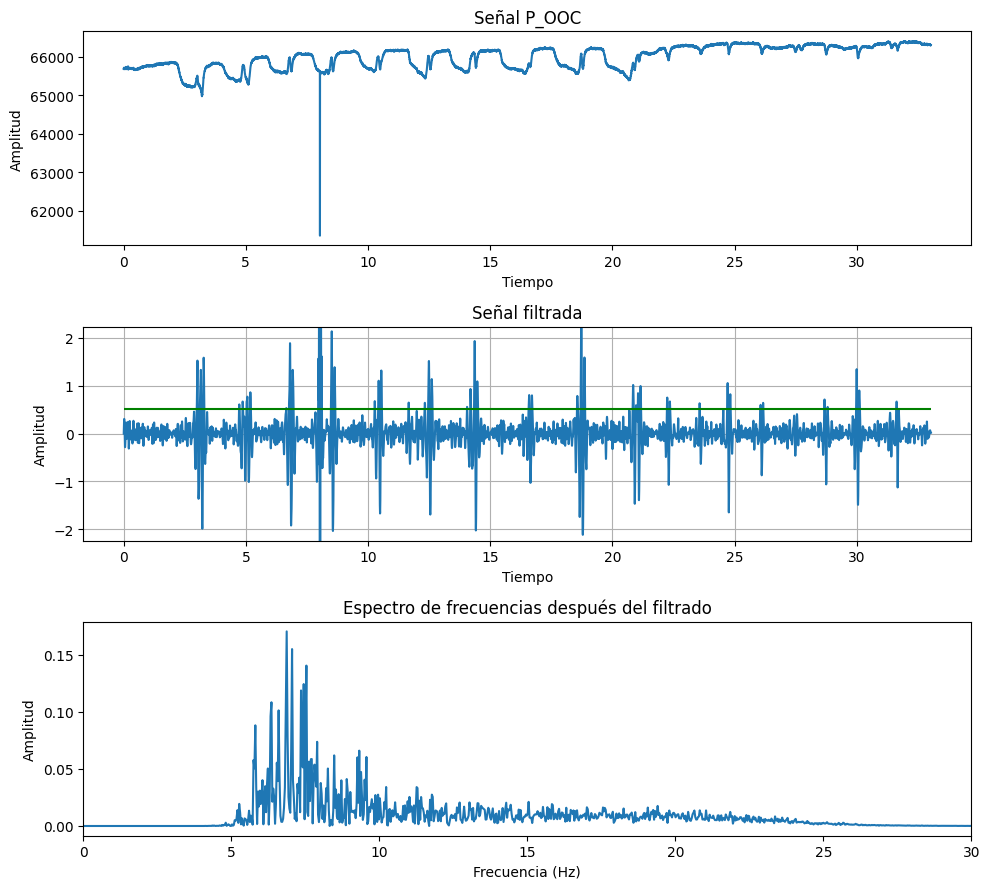

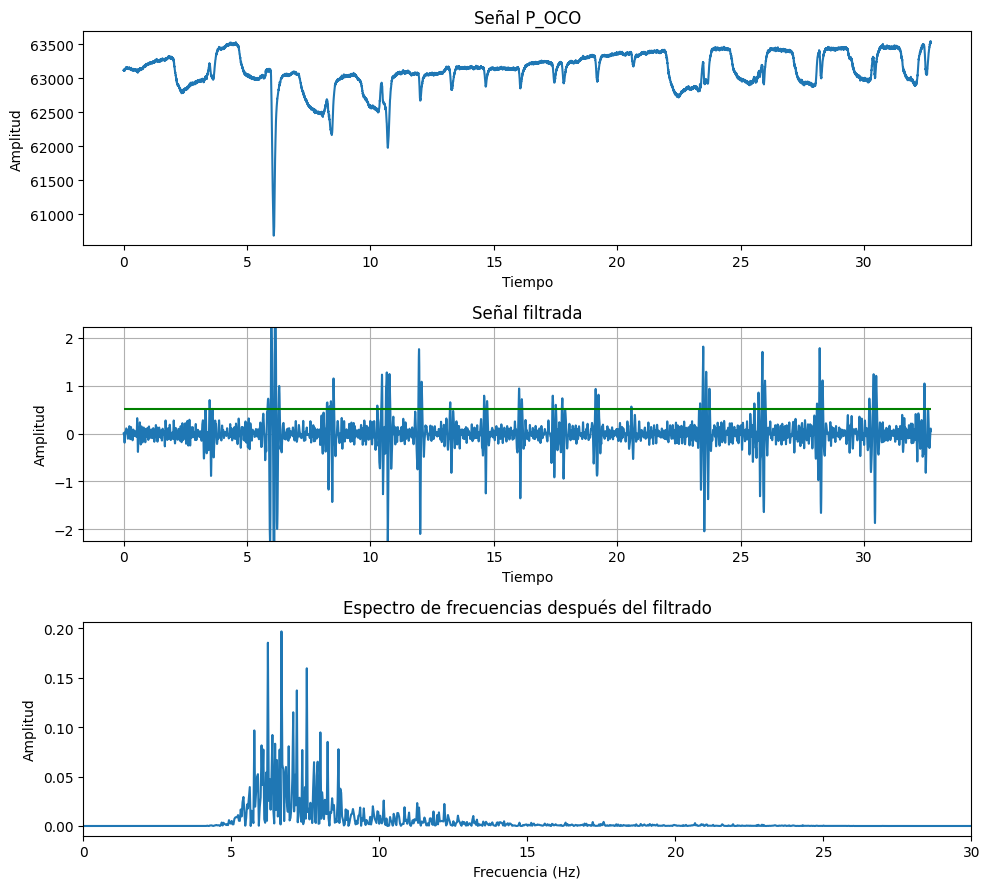

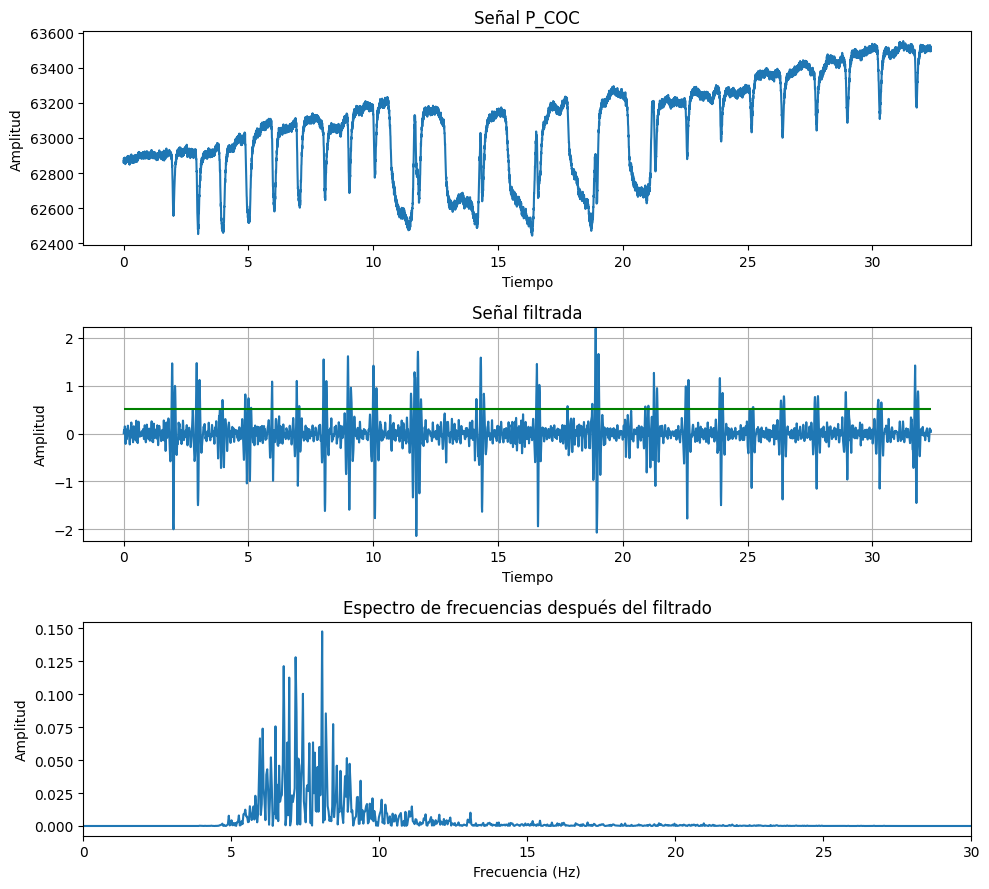

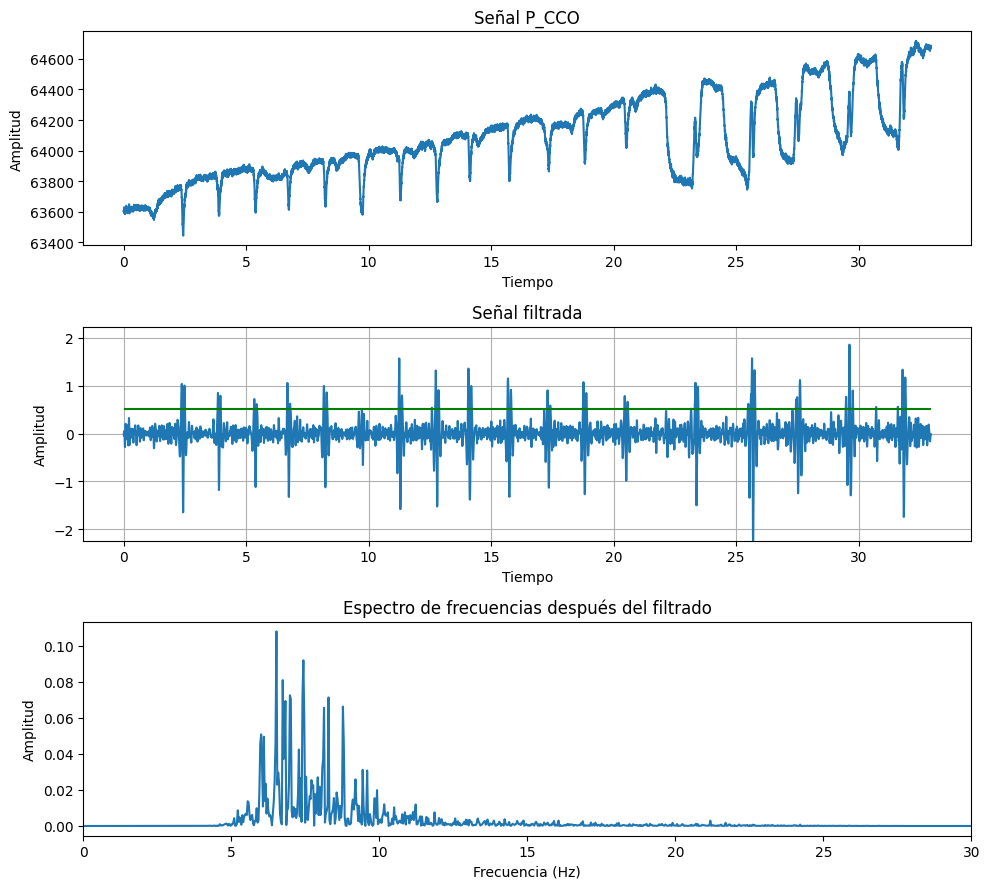

In [16]:
i=0
while i <=5:
    n=i
    plotear(signals,signals_f,times,titles,n)
    i=i+1

In [17]:
#Creación de data set
data_set={}
i=0
while i <=3:
    signal_filtered=signals_f[i+2]
    pico_st,pico,pos=detectar_picos(signal_filtered)
    picos,pos_picos_agrp=agrupar_picos(pico,pos,pico_st)
    tipo_onda,i_f_onda= tipos_onda(pos_picos_agrp,signal_filtered)
    megalist=partir_onda(tipo_onda,i_f_onda)
    codigo=codificar(megalist)

    target=np.repeat(codigo,signal_filtered.shape[0])
    x=[signal_filtered,target]

    data_set[str(i+2)]=x
    i=i+1



In [18]:
print(data_set)

{'2': [array([0.00214939, 0.09725362, 0.18335291, ..., 0.01244389, 0.01168346,
       0.01345301]), array(['110', '110', '110', ..., '110', '110', '110'], dtype='<U3')], '3': [array([ 0.00634934,  0.00376059, -0.00427931, ...,  0.10340686,
        0.08366413,  0.05072262]), array(['101', '101', '101', ..., '101', '101', '101'], dtype='<U3')], '4': [array([0.00559602, 0.03934542, 0.06392902, ..., 0.07199188, 0.05693654,
       0.03564642]), array(['010', '010', '010', ..., '010', '010', '010'], dtype='<U3')], '5': [array([-0.00889847, -0.03312874, -0.04407496, ..., -0.01007094,
       -0.01126855, -0.01596021]), array(['001', '001', '001', ..., '001', '001', '001'], dtype='<U3')]}


In [19]:
# Comprobamos que el codigo realmente diferencia los pestañeos largos de los cortos en conjunto
# Para ello, utilizaremos Power Spectral Entropy.
# Dado que en un mismo tiempo, los pestañeos cortos aparecerán más
# el PSE tendrá un menor valor
# De forma análoga, como los pestañeos largos aparecerán menor
# el PSE tendrá un mayor valor

pest_largo=signals_f[0]
pest_corto=signals_f[1]


In [20]:
# Para pestañeo largo

# Código detecta
pico_st,pico,pos=detectar_picos(pest_largo)
picos,pos_picos_agrp=agrupar_picos(pico,pos,pico_st)
tipo_onda,i_f_onda= tipos_onda(pos_picos_agrp,signal_filtered)

print("Código")
print(tipo_grupo(tipo_onda))
print("")

#PSE
print("PSE")
ant.spectral_entropy(signals[0],250,method='welch',normalize=True)

Código
Grupo de pestañeos largos

PSE


0.2952253536814948

In [21]:
# Para pestañeo largo

# Código detecta
pico_st,pico,pos=detectar_picos(pest_corto)
picos,pos_picos_agrp=agrupar_picos(pico,pos,pico_st)
tipo_onda,i_f_onda= tipos_onda(pos_picos_agrp,signal_filtered)
print("Código")
print(tipo_grupo(tipo_onda))
print("")
#PSE
print("PSE")
ant.spectral_entropy(signals[1],250,method='welch',normalize=True)

Código
Grupo de pestañeos cortos

PSE


0.4175588958418667